## Import Library

In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("D:/starAgile/datasets/CNN"))

['test', 'test.zip', 'train', 'train.zip']


## Define Constants

In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [3]:
filenames = os.listdir("D:/starAgile/datasets/CNN/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [5]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

## See Total In count

<Axes: xlabel='category'>

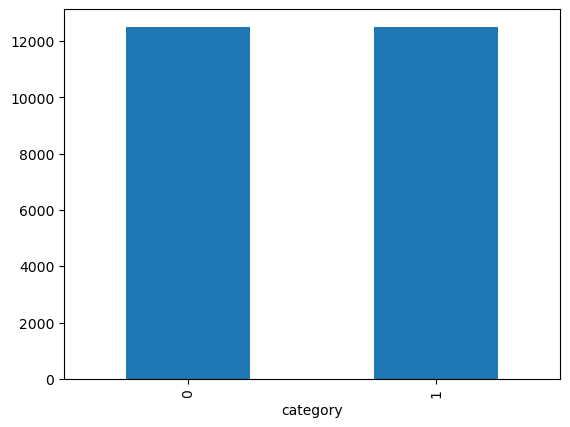

In [6]:
df['category'].value_counts().plot.bar()

## See sample image

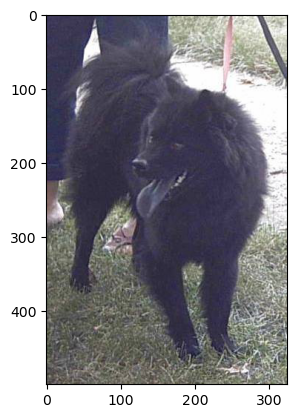

In [7]:
sample = random.choice(filenames)
image = load_img("D:/starAgile/datasets/CNN/train/train/"+sample)
plt.imshow(image)

## Build Model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 127008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,257,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,258,946 (62.02 MB)

 Trainable params: 16,258,626 (62.02 MB)

 Non-trainable params: 320 (1.25 KB)

## Callbacks

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Early Stop

In [11]:
earlystop = EarlyStopping(patience=10)

### Learning Rate Reduction

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [13]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare data

In [14]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

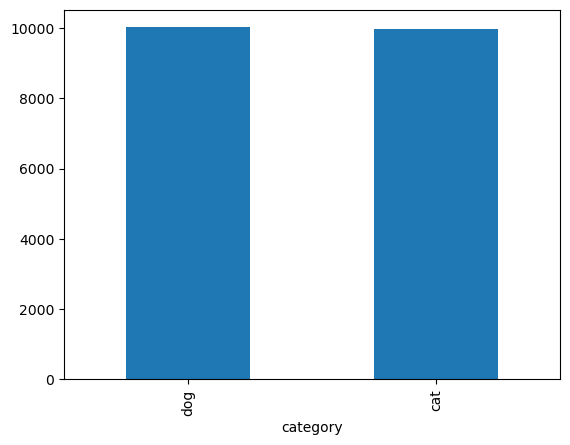

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

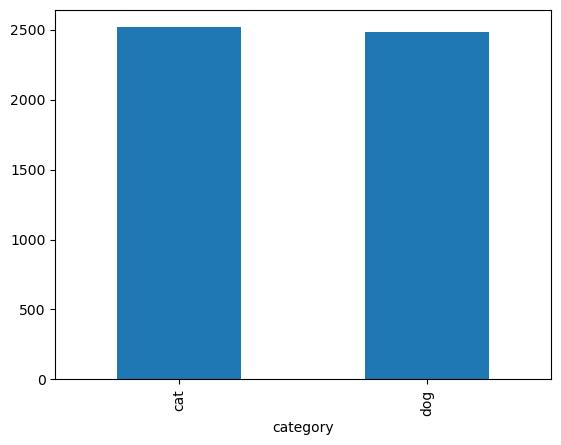

In [17]:
validate_df['category'].value_counts().plot.bar()

In [28]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=100

## Traning Generator

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "D:/starAgile/datasets/CNN/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation Generator

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "D:/starAgile/datasets/CNN/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [21]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "D:/starAgile/datasets/CNN/train/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


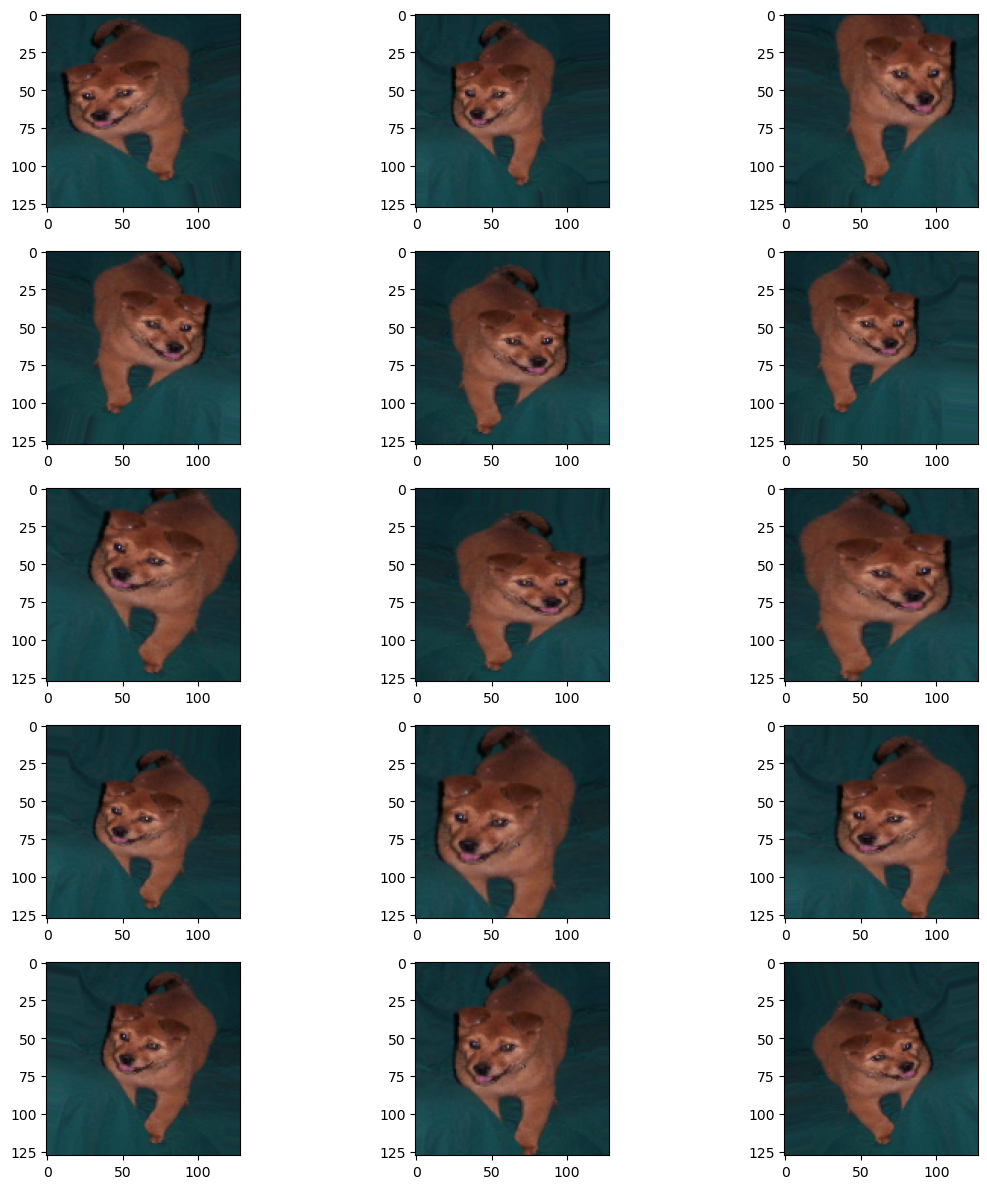

In [22]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [29]:
epochs=3 if FAST_RUN else 25
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 226ms/step - accuracy: 0.7567 - loss: 0.5185 - val_accuracy: 0.7533 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.7382 - loss: 0.5252 - val_accuracy: 0.7707 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.7586 - loss: 0.5054 - val_accuracy: 0.7067 - val_loss: 0.5848 - learning_rate: 0.0010
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 227ms/step - accuracy: 0.7499 - loss: 0.5196 - val_accuracy: 0.7693 - val_loss: 0.4764 - learning_rate: 0.0010
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.7394 - loss: 0.5111 - val_accuracy: 0.7733 - val_loss: 0.4801 - learning_rate: 0.0010
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.7377 - loss: 0.5205 - val_accuracy: 0.7507 - val_loss: 0.4947 - learning_rate: 0.0010
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 148ms/step - accuracy: 0.7

## Save Model

In [30]:
model.save("modelCatDog.h5")

## Virtualize Training

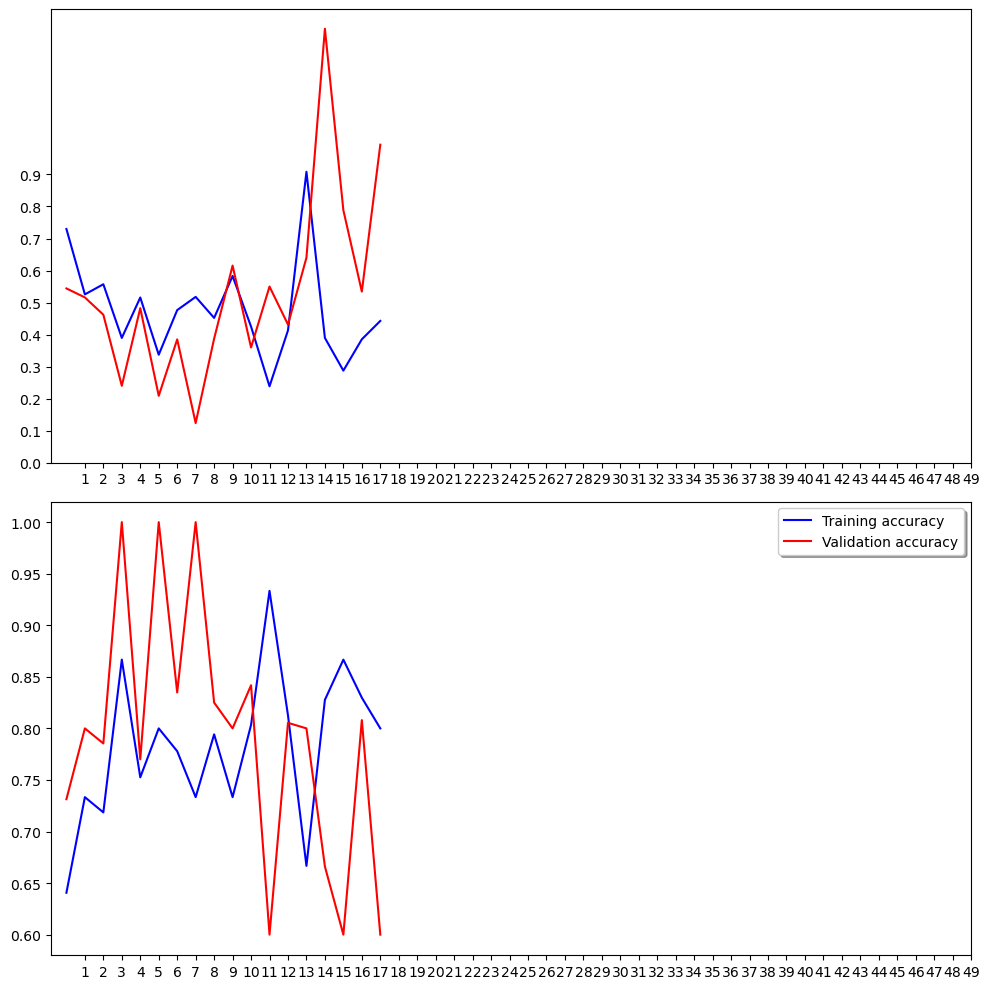

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [32]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [33]:
nb_samples

12500

## Create Testing Generator

In [35]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [38]:
np.ceil(nb_samples/batch_size)

125.0

## Predict

In [39]:
predict = model.predict(test_generator, steps=int(np.ceil(nb_samples/batch_size)))

C:\Users\akshay.s\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 370ms/step


In [40]:
test_df['category'] = np.argmax(predict, axis=-1)

In [41]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [42]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

C:\Users\akshay.s\AppData\Local\Temp\ipykernel_11116\163432756.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })


## Virtaulize Result

<Axes: xlabel='category'>

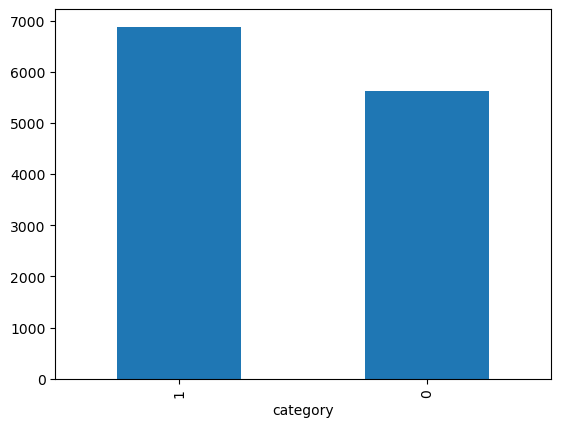

In [43]:
test_df['category'].value_counts().plot.bar()

## See predicted result with images

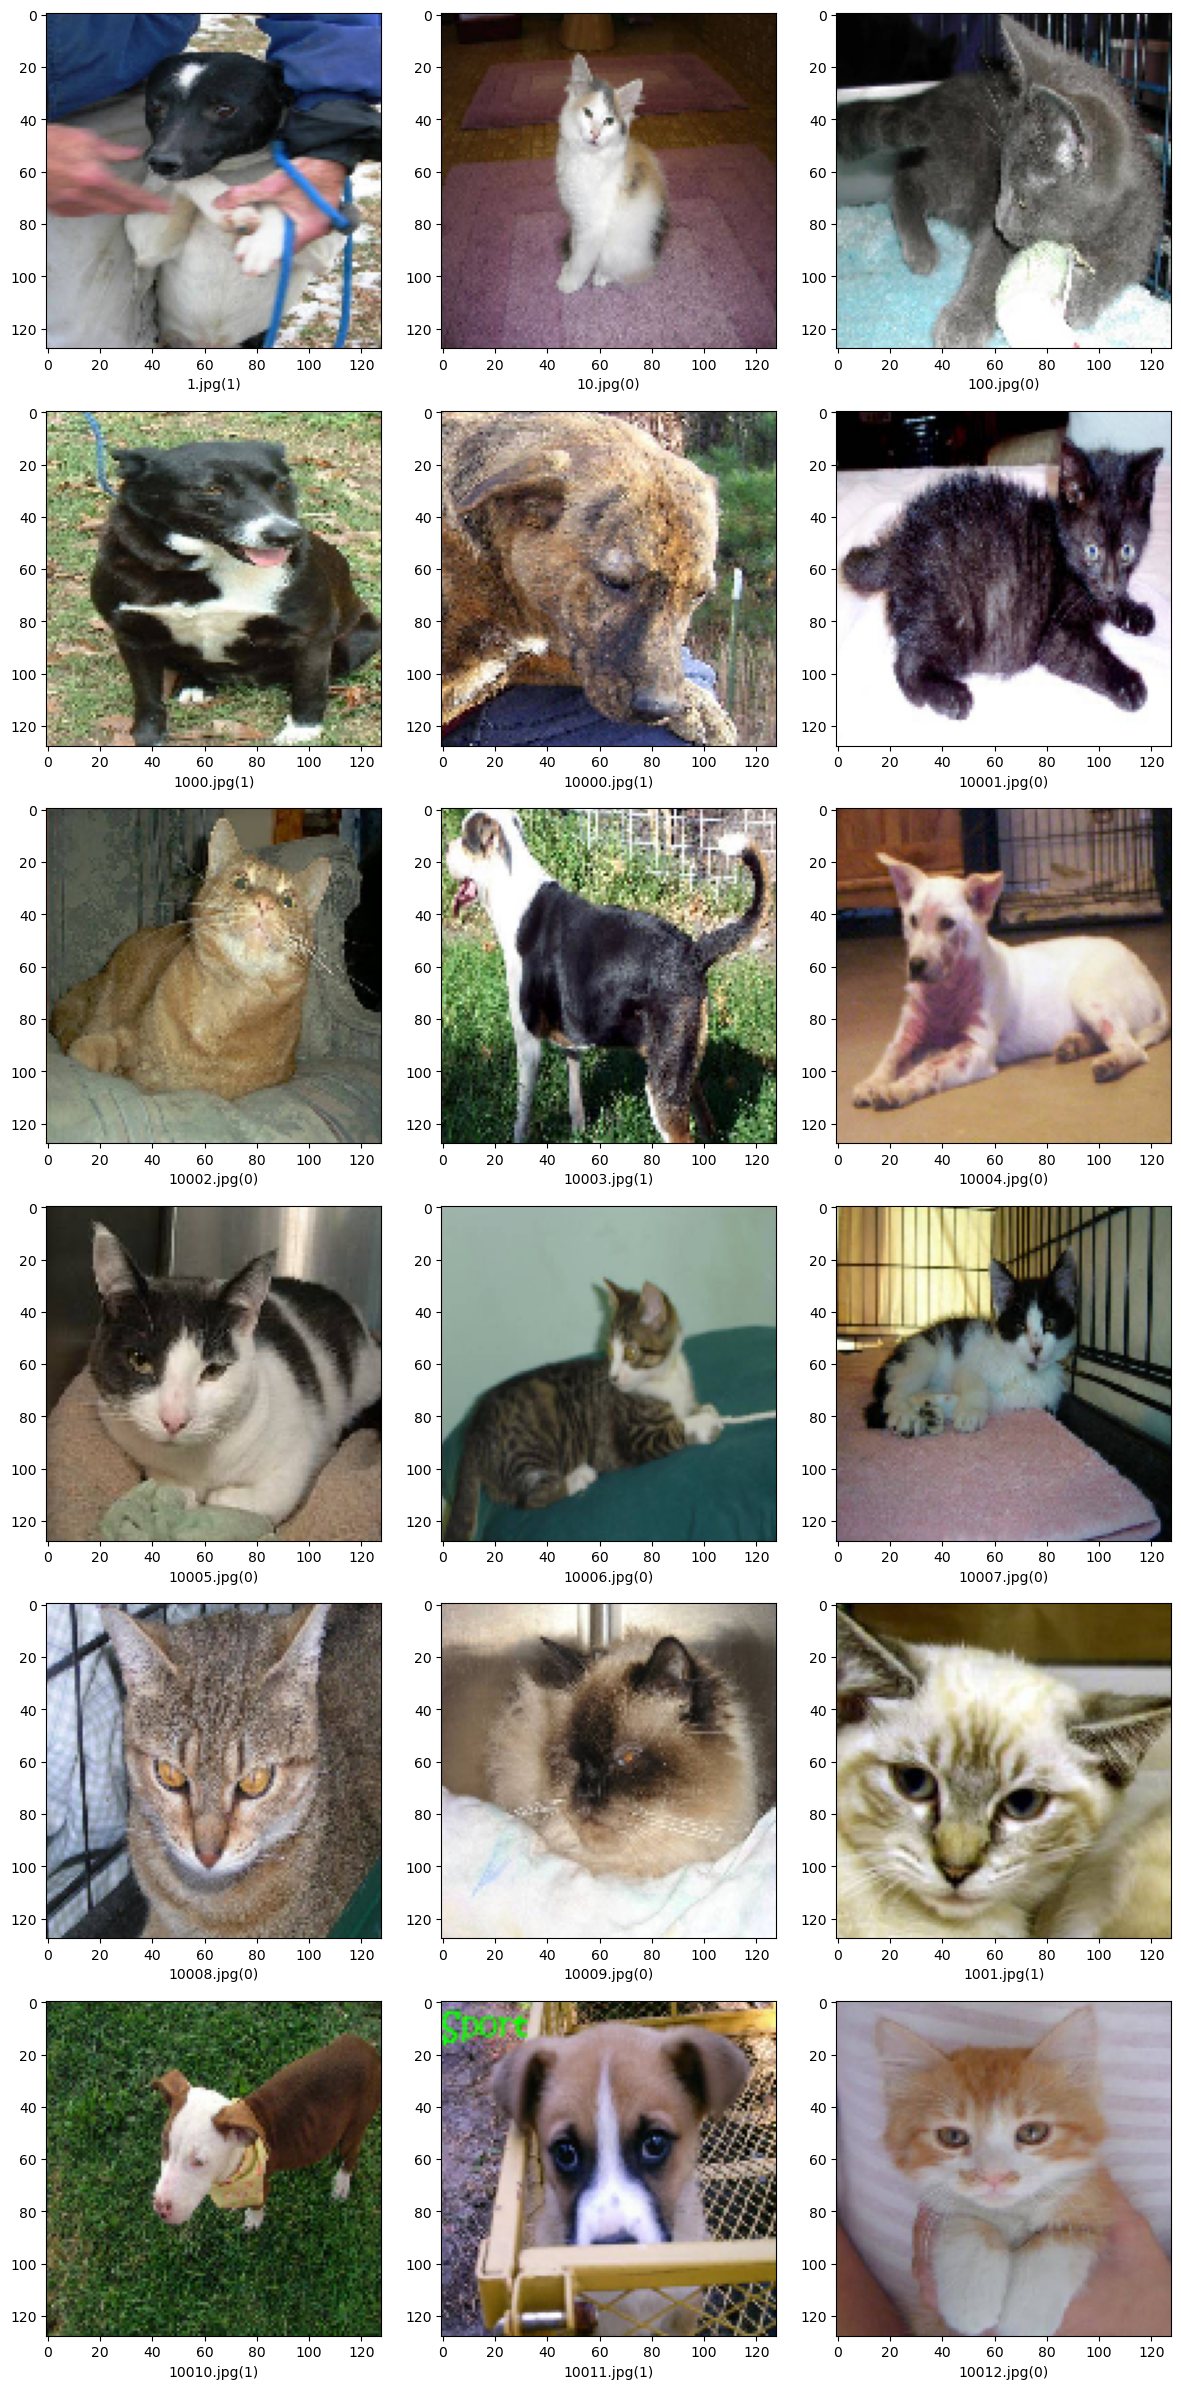

In [45]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

## Submission

In [46]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

## We got 75% accuracy on trainning and 78% accuracy on validation